##Import Libraries##

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162994 sha256=8b1cdad7ba775a96871c1ef0489455fb02edd255eb9123ce68ab438166569c8c
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

##Import Dataset

The dataset is retrieved from https://www.kaggle.com/datasets/dev0914sharma/dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_rating = pd.read_csv('/content/drive/My Drive/Movie Recommendation System/Dataset.csv')
df_title = pd.read_csv('/content/drive/My Drive/Movie Recommendation System/Movie.csv')

In [ ]:
df_rating.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [ ]:
df_rating['converted_timestamp'] = pd.to_datetime(df_rating['timestamp'], unit='s')
print(df_rating['converted_timestamp'])

0        1997-12-04 15:55:49
1        1997-12-04 15:55:49
2        1997-12-04 15:55:49
3        1997-12-04 15:55:49
4        1998-04-04 19:22:22
                 ...        
99998    1997-11-22 05:10:44
99999    1997-11-17 19:39:03
100000   1997-09-20 22:49:55
100001   1997-12-17 22:52:36
100002   1997-11-19 17:13:03
Name: converted_timestamp, Length: 100003, dtype: datetime64[ns]


In [ ]:
earliest = df_rating['converted_timestamp'].min()
latest = df_rating['converted_timestamp'].max()
print(earliest)
print(latest)

1997-09-20 03:05:10
1998-04-22 23:10:38


In [ ]:
df_title.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
df_rating.shape

(100003, 5)

In [ ]:
unique_user_ids = len(df_rating['user_id'].unique())
unique_user_ids

944

In [ ]:
unique_title = len(df_title['title'].unique())
unique_title

1664

In [ ]:
df_rating.drop(columns=['timestamp'], inplace=True)

In [ ]:
df_rating.describe()

,user_id,item_id,rating
count,100003.000000,100003.000000,100003.000000
mean,462.470876,425.520914,3.529864
std,266.622454,330.797791,1.125704
min,0.000000,1.000000,1.000000
25%,254.000000,175.000000,3.000000
50%,447.000000,322.000000,4.000000
75%,682.000000,631.000000,4.000000
max,943.000000,1682.000000,5.000000


In [ ]:
df_rating.isnull().sum()

user_id                0
item_id                0
rating                 0
converted_timestamp    0
dtype: int64

In [ ]:
df_title.isnull().sum()

item_id    0
title      0
dtype: int64

In [ ]:
(df_rating['rating'] == 0).sum()

0

In [ ]:
#Merge df_rating with df_title to analyze ratings along with movie titles.
merged_df = pd.merge(df_rating, df_title, on='item_id', how='inner')
print(merged_df.head())

   user_id  item_id  rating converted_timestamp             title
0        0       50       5 1997-12-04 15:55:49  Star Wars (1977)
1      290       50       5 1997-11-25 15:59:42  Star Wars (1977)
2       79       50       4 1998-03-30 15:25:45  Star Wars (1977)
3        2       50       5 1998-02-27 04:01:24  Star Wars (1977)
4        8       50       5 1997-11-12 19:15:24  Star Wars (1977)


##EDA

<ipython-input-21-ed5d2a46a818>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes = sns.countplot(x='rating', data=df_rating, palette='muted')


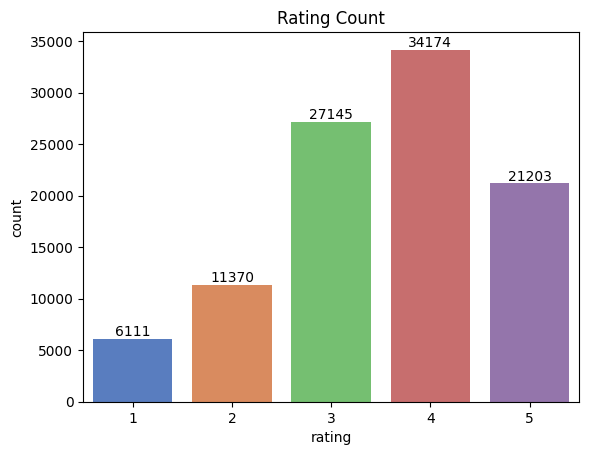

In [ ]:
plt.title('Rating Count')

axes = sns.countplot(x='rating', data=df_rating, palette='muted')

# Add count labels to each bar
for p in axes.patches:
    axes.text(p.get_x() + p.get_width()/2., p.get_height(),
            '%d' % int(p.get_height()),
            ha='center', va='bottom')

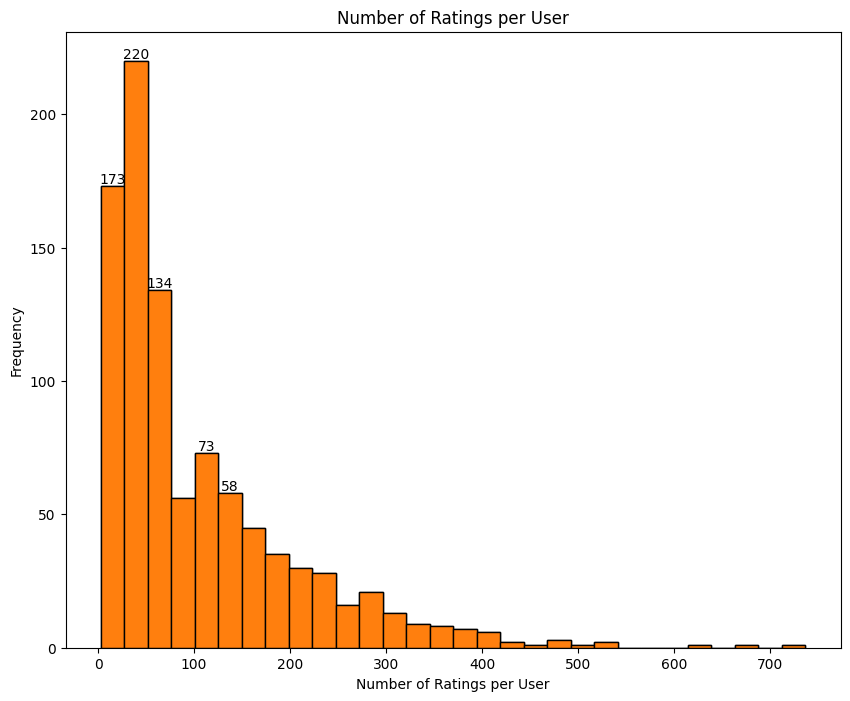

In [ ]:
plt.figure(figsize=(10,8))
ratings_per_user = df_rating.groupby('user_id').size()
plt.hist(ratings_per_user, bins=30, edgecolor='black')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Number of Ratings per User')

# Get the histogram counts
counts, bins, patches = plt.hist(ratings_per_user, bins=30, edgecolor='black')

# Find the highest 5 counts
top_5_counts = sorted(counts, reverse=True)[:5]

# Add text annotations for the highest 5 bars
for i, patch in enumerate(patches):
    count = counts[i]
    if count in top_5_counts:
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), ha='center', va='bottom')

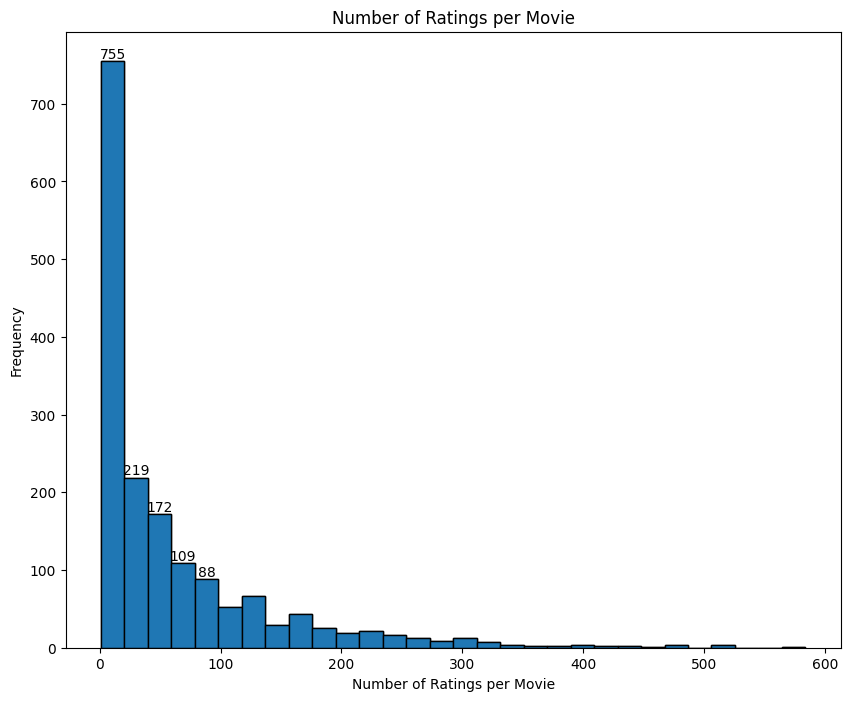

In [ ]:
ratings_per_movie = df_rating.groupby('item_id').size()
plt.figure(figsize=(10, 8))

plt.hist(ratings_per_movie, bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Frequency')
plt.title('Number of Ratings per Movie')

# Get the histogram counts
counts, bins, patches = plt.hist(ratings_per_movie, bins=30, edgecolor='black')

# Find the highest 5 counts
top_5_counts = sorted(counts, reverse=True)[:5]

# Add text annotations for the highest 5 bars
for i, patch in enumerate(patches):
    count = counts[i]
    if count in top_5_counts:
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), ha='center', va='bottom')

plt.show()

Top 10 Popular Movies:
title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
dtype: int64


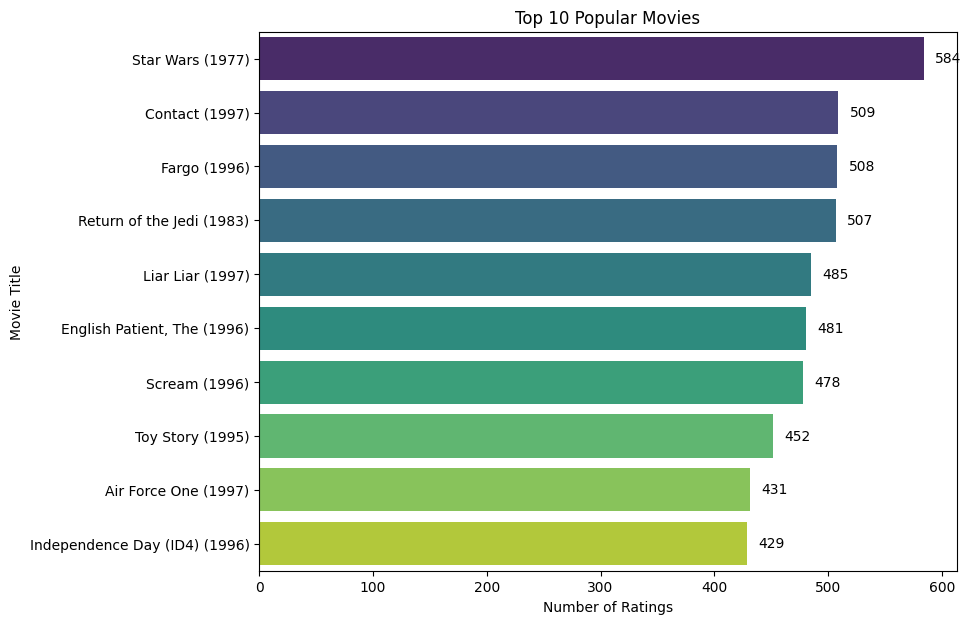

In [ ]:
popular_movies = merged_df.groupby('title').size().sort_values(ascending=False)[:10]
print("Top 10 Popular Movies:")
print(popular_movies)

plt.figure(figsize=(9,7))
sns.barplot(x=popular_movies.values, y=popular_movies.index, palette='viridis', hue=popular_movies.index, legend=False)
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Popular Movies')

# Add value labels to the bars
for i, v in enumerate(popular_movies.values):
    plt.text(v + 10, i, str(v), color='black', va='center')

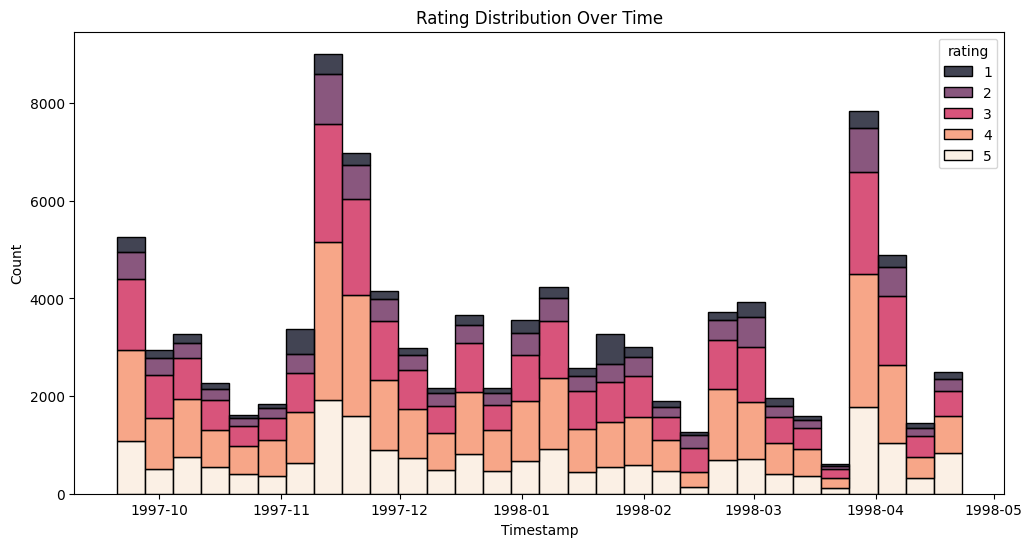

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(data=merged_df, x='converted_timestamp', hue='rating', bins=30, palette='rocket', multiple='stack')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Rating Distribution Over Time')

plt.show()

Average Rating per Movie:
title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64


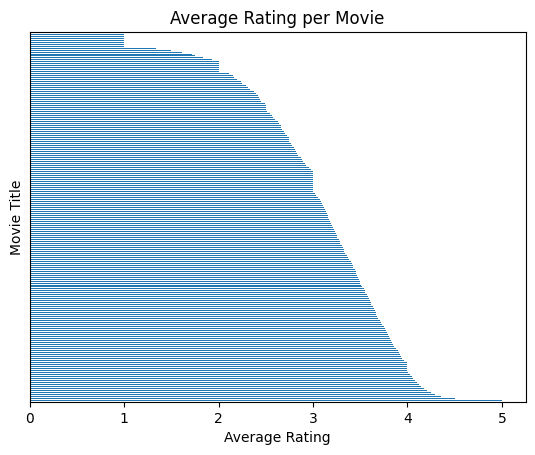

In [ ]:
# average_rating_per_movie = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False)
# print("Average Rating per Movie:")
# print(average_rating_per_movie.head())

# average_rating_per_movie.plot(kind='barh')
# plt.xlabel('Average Rating')
# plt.ylabel('Movie Title')
# plt.yticks([])
# plt.title('Average Rating per Movie')
# plt.show()

##Recommendation System##

In [ ]:
merged_df

,user_id,item_id,rating,converted_timestamp,title
0,0,50,5,1997-12-04 15:55:49,Star Wars (1977)
1,290,50,5,1997-11-25 15:59:42,Star Wars (1977)
2,79,50,4,1998-03-30 15:25:45,Star Wars (1977)
3,2,50,5,1998-02-27 04:01:24,Star Wars (1977)
4,8,50,5,1997-11-12 19:15:24,Star Wars (1977)
...,...,...,...,...,...
99998,840,1674,4,1998-03-29 22:48:02,Mamma Roma (1962)
99999,655,1640,3,1998-02-26 06:30:46,"Eighth Day, The (1996)"
100000,655,1637,3,1998-03-04 04:04:15,Girls Town (1996)
100001,655,1630,3,1998-02-14 03:58:55,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [ ]:
# Load the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_df[['user_id', 'item_id', 'rating']], reader)

# Use the SVD algorithm (A matrix factorization-based collaborative filtering algorithm commonly used for recommendation systems)
algo = SVD()

# Perform 5-fold cross-validation on the trained algorithm (algo) using the dataset (data).
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Function to get top N movie recommendations for a given user
def get_top_n_recommendations(user_id, n=10):
    # Extract movie IDs that are already rated by the user from training set
    rated_movie_ids = [r[0] for r in trainset.ur[user_id]]

    # Predict ratings for all movies not rated by the user
    movies_to_predict = [iid for iid in merged_df['item_id'].unique() if iid not in rated_movie_ids]
    testset = [[user_id, iid, 4] for iid in movies_to_predict]  # Use a placeholder rating of 4 for prediction
    # This test set contains the user ID, the movie ID, and a placeholder rating of 4 for each movie not rated by the user.
    predictions = algo.test(testset)
    # Use trained recommendation algorithm (algo) to predict ratings for the movies in the test set.
    # algo.test takes the test set as input and predicts ratings for each movie.

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommendations
    top_n_recommendations = [(algo.trainset.to_raw_iid(pred.iid), pred.est) for pred in predictions[:n]]
    return top_n_recommendations

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9339  0.9308  0.9340  0.9377  0.9373  0.9347  0.0025  
MAE (testset)     0.7374  0.7337  0.7340  0.7397  0.7410  0.7372  0.0029  
Fit time          4.52    2.70    2.77    1.38    1.98    2.67    1.05    
Test time         0.27    0.26    0.26    0.11    0.20    0.22    0.06    


In [ ]:
# Trial
user_id = 27
top_recommendations = get_top_n_recommendations(user_id)
print(f"Top recommendations for user {user_id}:")
for movie_id, estimated_rating in top_recommendations:
    movie_title = merged_df.loc[merged_df['item_id'] == movie_id, 'title'].values[0]
    print(f"{movie_title} (Estimated Rating: {estimated_rating:.2f})")

Top recommendations for user 27:
Big Night (1996) (Estimated Rating: 4.35)
Amistad (1997) (Estimated Rating: 4.34)
Room with a View, A (1986) (Estimated Rating: 4.34)
Touch (1997) (Estimated Rating: 4.34)
Vertigo (1958) (Estimated Rating: 4.34)
Monty Python and the Holy Grail (1974) (Estimated Rating: 4.26)
Highlander (1986) (Estimated Rating: 4.25)
Playing God (1997) (Estimated Rating: 4.25)
Phantoms (1998) (Estimated Rating: 4.21)
Fly Away Home (1996) (Estimated Rating: 4.20)


##Reference
https://surpriselib.com

https://www.kaggle.com/datasets/dev0914sharma/dataset